# Cross-Location Model Analysis

This notebook analyzes how the best model for each location performs when applied to other locations, providing insights into model generalization across different markets.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Traditional ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Nixtla client for TimeGPT
from nixtla import NixtlaClient

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the consolidated data
df = pd.read_csv('../outputs/data/sales_weather_merged_filled_consolidated.csv')
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Locations: {df['Location'].unique()}")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Location', 'date']).reset_index(drop=True)

df.head()


Data shape: (286, 18)
Date range: 2019-04-01 to 2024-03-01
Locations: ['Bangalore' 'Chennai' 'Cochin' 'Secunderabad' 'Vijaywada' 'Sricity']


,Location,QTY,temp_min,temp_max,temp_mean,dwpt_min,dwpt_max,dwpt_mean,rhum_min,rhum_max,rhum_mean,prcp_min,prcp_max,prcp_mean,wspd_min,wspd_max,wspd_mean,date
0,Bangalore,1678.0,15.0,34.40,25.490457,-2.240,21.820,12.241344,11.20,99.6,49.995161,0.0,1.875000,0.009845,1.08,34.480,10.858306,2019-04-01
1,Bangalore,3951.0,19.0,35.25,27.041071,0.775,23.275,15.193029,12.25,100.0,54.193651,0.0,7.766667,0.056111,0.00,36.625,10.347719,2019-05-01
2,Bangalore,4709.0,19.6,34.40,26.270377,10.240,24.420,19.395948,24.80,100.0,69.900511,0.0,8.166667,0.159319,0.00,38.960,13.101580,2019-06-01
3,Bangalore,2418.0,19.6,32.40,24.810296,14.280,24.020,19.992738,38.00,100.0,76.857086,0.0,7.800000,0.155787,1.44,41.540,17.832391,2019-07-01
4,Bangalore,2252.0,19.6,30.40,23.654283,16.740,23.260,20.154345,45.40,100.0,82.423583,0.0,7.633333,0.201703,1.44,41.600,18.792103,2019-08-01


In [3]:
# Define the best models for each location based on the results
best_models_per_location = {
    'Bangalore': {'Model_Type': 'Time Series', 'Model_Name': 'SARIMA'},
    'Chennai': {'Model_Type': 'Time Series', 'Model_Name': 'ETS'},
    'Cochin': {'Model_Type': 'ML', 'Model_Name': 'Extra Trees'},
    'Secunderabad': {'Model_Type': 'ML', 'Model_Name': 'Gradient Boosting'},
    'Vijaywada': {'Model_Type': 'Time Series', 'Model_Name': 'SARIMA'}
}

print("Best models per location:")
for location, model_info in best_models_per_location.items():
    print(f"{location}: {model_info['Model_Type']} - {model_info['Model_Name']}")


Best models per location:
Bangalore: Time Series - SARIMA
Chennai: Time Series - ETS
Cochin: ML - Extra Trees
Secunderabad: ML - Gradient Boosting
Vijaywada: Time Series - SARIMA


In [4]:
# Import the functions from the original notebook
def create_time_features(df):
    """
    Create comprehensive time-based features for forecasting
    """
    df = df.copy()
    
    # Extract temporal indicators
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Cyclical encoding for seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    # Weather interaction features
    if 'temp_mean' in df.columns and 'rhum_mean' in df.columns:
        df['temp_humidity_interaction'] = df['temp_mean'] * df['rhum_mean']
    if 'temp_mean' in df.columns and 'wspd_mean' in df.columns:
        df['temp_wind_interaction'] = df['temp_mean'] * df['wspd_mean']
    
    return df

def create_lag_and_rolling_features(df, target_col='QTY', lags=[1, 2, 3, 6, 12], windows=[3, 6, 12]):
    """
    Create lag and rolling features to prevent data leakage
    """
    df = df.copy()
    
    # Create lag features (only using past data)
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Create rolling statistics (only using past data)
    for window in windows:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean().shift(1)
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1)
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min().shift(1)
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max().shift(1)
    
    return df

def prepare_location_data(df, location, test_months=12):
    """
    Prepare data for a specific location with train/test split
    """
    # Filter data for specific location
    location_df = df[df['Location'] == location].copy()
    location_df = location_df.sort_values('date').reset_index(drop=True)
    
    # Check if we have enough data
    if len(location_df) < test_months + 12:  # Need at least 12 months for training + test_months
        print(f"Warning: {location} has insufficient data ({len(location_df)} records). Skipping.")
        return None
    
    # Create time features
    location_df = create_time_features(location_df)
    
    # Create lag and rolling features
    location_df = create_lag_and_rolling_features(location_df)
    
    # Split data: last test_months for testing
    split_idx = len(location_df) - test_months
    train_df = location_df.iloc[:split_idx].copy()
    test_df = location_df.iloc[split_idx:].copy()
    
    # Remove rows with NaN from lag/rolling features in training set
    train_df = train_df.dropna().reset_index(drop=True)
    
    # Check if we have any training data left
    if len(train_df) == 0:
        print(f"Warning: {location} has no valid training data after feature engineering. Skipping.")
        return None
    
    # Define feature columns (exclude target and non-feature columns)
    exclude_cols = ['QTY', 'date', 'Location']
    feature_cols = [col for col in location_df.columns if col not in exclude_cols]
    
    # Prepare features and target
    X_train = train_df[feature_cols].fillna(0)  # Fill any remaining NaN with 0
    y_train = train_df['QTY']
    X_test = test_df[feature_cols].fillna(0)
    y_test = test_df['QTY']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train.values,
        'y_test': y_test.values,
        'train_df': train_df,
        'test_df': test_df,
        'feature_cols': feature_cols,
        'scaler': scaler
    }

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

print("Helper functions loaded successfully!")


Helper functions loaded successfully!


In [5]:
# Define model training functions
def train_ml_model(model_name, X_train, y_train, X_test, y_test):
    """
    Train a specific ML model
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1),
        'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=False),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }
    
    if model_name not in models:
        return None
    
    try:
        model = models[model_name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return calculate_metrics(y_test, y_pred)
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        return None

def train_arima_model(train_df, test_df):
    """
    Train ARIMA model
    """
    try:
        model = ARIMA(train_df['QTY'], order=(1, 1, 1))
        fitted_model = model.fit()
        y_pred = fitted_model.forecast(steps=len(test_df))
        return calculate_metrics(test_df['QTY'], y_pred)
    except Exception as e:
        print(f"ARIMA failed: {str(e)}")
        return None

def train_sarima_model(train_df, test_df):
    """
    Train SARIMA model
    """
    try:
        model = SARIMAX(train_df['QTY'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fitted_model = model.fit(disp=False)
        y_pred = fitted_model.forecast(steps=len(test_df))
        return calculate_metrics(test_df['QTY'], y_pred)
    except Exception as e:
        print(f"SARIMA failed: {str(e)}")
        return None

def train_prophet_model(train_df, test_df):
    """
    Train Prophet model
    """
    try:
        prophet_train = pd.DataFrame({
            'ds': train_df['date'],
            'y': train_df['QTY']
        })
        
        prophet_test = pd.DataFrame({
            'ds': test_df['date']
        })
        
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        
        model.fit(prophet_train)
        forecast = model.predict(prophet_test)
        y_pred = forecast['yhat'].values
        return calculate_metrics(test_df['QTY'], y_pred)
    except Exception as e:
        print(f"Prophet failed: {str(e)}")
        return None

def train_ets_model(train_df, test_df):
    """
    Train Exponential Smoothing model
    """
    try:
        if len(train_df) < 24:  # Need at least 2 seasonal cycles
            model = ExponentialSmoothing(
                train_df['QTY'],
                trend='add',
                seasonal=None
            )
        else:
            model = ExponentialSmoothing(
                train_df['QTY'],
                trend='add',
                seasonal='add',
                seasonal_periods=12
            )
        
        fitted_model = model.fit()
        y_pred = fitted_model.forecast(len(test_df))
        return calculate_metrics(test_df['QTY'], y_pred)
    except Exception as e:
        print(f"ETS failed: {str(e)}")
        return None

print("Model training functions defined successfully!")


Model training functions defined successfully!


In [6]:
# Cross-location analysis: Apply best model from each location to all other locations
print("Cross-Location Model Analysis")
print("="*60)

# Get all locations
all_locations = df['Location'].unique()
print(f"All locations: {all_locations}")

# Initialize results storage
cross_location_results = []

# For each best model, test it on all locations
for source_location, model_info in best_models_per_location.items():
    print(f"\n{'='*60}")
    print(f"Testing {model_info['Model_Name']} (best for {source_location}) on all locations")
    print(f"{'='*60}")
    
    model_type = model_info['Model_Type']
    model_name = model_info['Model_Name']
    
    for target_location in all_locations:
        print(f"\nTesting on {target_location}...")
        
        # Prepare data for target location
        location_data = prepare_location_data(df, target_location)
        
        if location_data is None:
            print(f"  ✗ Skipping {target_location} - insufficient data")
            continue
        
        try:
            start_time = datetime.now()
            
            # Train model based on type
            if model_type == 'ML':
                metrics = train_ml_model(
                    model_name,
                    location_data['X_train'],
                    location_data['y_train'],
                    location_data['X_test'],
                    location_data['y_test']
                )
            elif model_type == 'Time Series':
                if model_name == 'ARIMA':
                    metrics = train_arima_model(location_data['train_df'], location_data['test_df'])
                elif model_name == 'SARIMA':
                    metrics = train_sarima_model(location_data['train_df'], location_data['test_df'])
                elif model_name == 'Prophet':
                    metrics = train_prophet_model(location_data['train_df'], location_data['test_df'])
                elif model_name == 'ETS':
                    metrics = train_ets_model(location_data['train_df'], location_data['test_df'])
                else:
                    metrics = None
            else:
                metrics = None
            
            training_time = (datetime.now() - start_time).total_seconds()
            
            if metrics is not None:
                cross_location_results.append({
                    'Source_Location': source_location,
                    'Target_Location': target_location,
                    'Model_Type': model_type,
                    'Model_Name': model_name,
                    'MAE': metrics['MAE'],
                    'RMSE': metrics['RMSE'],
                    'MAPE': metrics['MAPE'],
                    'R2': metrics['R2'],
                    'Training_Time': training_time
                })
                print(f"  ✓ {model_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
            else:
                print(f"  ✗ {model_name}: Failed")
                
        except Exception as e:
            print(f"  ✗ {model_name}: Error - {str(e)}")

print(f"\n{'='*60}")
print(f"Cross-location analysis completed!")
print(f"Total results: {len(cross_location_results)}")
print(f"{'='*60}")


Cross-Location Model Analysis
All locations: ['Bangalore' 'Chennai' 'Cochin' 'Secunderabad' 'Sricity' 'Vijaywada']

Testing SARIMA (best for Bangalore) on all locations

Testing on Bangalore...


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=692.39, RMSE=1218.23, R²=0.755

Testing on Chennai...


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=6291.24, RMSE=7511.02, R²=-0.754

Testing on Cochin...


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=2993.84, RMSE=3880.94, R²=-0.002

Testing on Secunderabad...
  ✓ SARIMA: MAE=4672.99, RMSE=7630.03, R²=0.313

Testing on Sricity...
  ✗ Skipping Sricity - insufficient data

Testing on Vijaywada...


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=2788.55, RMSE=3535.57, R²=0.144

Testing ETS (best for Chennai) on all locations

Testing on Bangalore...
  ✓ ETS: MAE=1115.29, RMSE=1267.20, R²=0.735

Testing on Chennai...
  ✓ ETS: MAE=3187.25, RMSE=5075.99, R²=0.199

Testing on Cochin...
  ✓ ETS: MAE=2967.50, RMSE=3654.74, R²=0.111

Testing on Secunderabad...
  ✓ ETS: MAE=5633.33, RMSE=8224.03, R²=0.202

Testing on Sricity...
  ✗ Skipping Sricity - insufficient data

Testing on Vijaywada...
  ✓ ETS: MAE=3367.38, RMSE=4082.64, R²=-0.141

Testing Extra Trees (best for Cochin) on all locations

Testing on Bangalore...
  ✓ Extra Trees: MAE=1896.71, RMSE=2494.48, R²=-0.029

Testing on Chennai...
  ✓ Extra Trees: MAE=4853.09, RMSE=5645.71, R²=0.009

Testing on Cochin...
  ✓ Extra Trees: MAE=2911.54, RMSE=3687.01, R²=0.095

Testing on Secunderabad...
  ✓ Extra Trees: MAE=5336.78, RMSE=8121.80, R²=0.221

Testing on Sricity...
  ✗ Skipping Sricity - insufficient data

Testing on Vijaywada...
  ✓ Extra Trees: MAE=3841.73, RMSE

e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=692.39, RMSE=1218.23, R²=0.755

Testing on Chennai...


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=6291.24, RMSE=7511.02, R²=-0.754

Testing on Cochin...


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  ✓ SARIMA: MAE=2993.84, RMSE=3880.94, R²=-0.002

Testing on Secunderabad...
  ✓ SARIMA: MAE=4672.99, RMSE=7630.03, R²=0.313

Testing on Sricity...
  ✗ Skipping Sricity - insufficient data

Testing on Vijaywada...
  ✓ SARIMA: MAE=2788.55, RMSE=3535.57, R²=0.144

Cross-location analysis completed!
Total results: 25


e:\Programs\COMPANY\Sashflow\project_future_projection\rnd\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# Convert results to DataFrame
cross_results_df = pd.DataFrame(cross_location_results)

print(f"Cross-location results shape: {cross_results_df.shape}")
print(f"\nFirst few results:")
print(cross_results_df.head())

# Save results
import os
os.makedirs('../outputs/model_results', exist_ok=True)
cross_results_df.to_csv('../outputs/model_results/cross_location_analysis.csv', index=False)
print(f"\nResults saved to: ../outputs/model_results/cross_location_analysis.csv")


Cross-location results shape: (25, 9)

First few results:
  Source_Location Target_Location   Model_Type Model_Name          MAE  \
0       Bangalore       Bangalore  Time Series     SARIMA   692.394536   
1       Bangalore         Chennai  Time Series     SARIMA  6291.240232   
2       Bangalore          Cochin  Time Series     SARIMA  2993.838766   
3       Bangalore    Secunderabad  Time Series     SARIMA  4672.985812   
4       Bangalore       Vijaywada  Time Series     SARIMA  2788.552931   

          RMSE  MAPE        R2  Training_Time  
0  1218.232270   NaN  0.754654       0.392596  
1  7511.018652   NaN -0.754417       0.453056  
2  3880.944745   NaN -0.002312       0.387780  
3  7630.025613   NaN  0.312797       0.323413  
4  3535.565300   NaN  0.143998       0.348248  

Results saved to: ../outputs/model_results/cross_location_analysis.csv


In [8]:
# Analysis 1: How well does each best model perform on other locations?
print("\n" + "="*80)
print("ANALYSIS 1: Model Performance Across Locations")
print("="*80)

# Performance of each best model across all locations
print("\n--- Performance of Best Models Across All Locations ---")
model_performance = cross_results_df.groupby(['Source_Location', 'Model_Name']).agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(3)

print(model_performance)

# Best performing model overall
print("\n--- Best Performing Model Overall (by average MAE) ---")
best_overall = cross_results_df.groupby(['Source_Location', 'Model_Name'])['MAE'].mean().reset_index()
best_overall = best_overall.sort_values('MAE')
print(best_overall.head(10))



ANALYSIS 1: Model Performance Across Locations

--- Performance of Best Models Across All Locations ---
                                        MAE                                \
                                       mean       std       min       max   
Source_Location Model_Name                                                  
Bangalore       SARIMA             3487.802  2110.165   692.395  6291.240   
Chennai         ETS                3254.150  1607.382  1115.290  5633.334   
Cochin          Extra Trees        3767.968  1403.493  1896.706  5336.776   
Secunderabad    Gradient Boosting  3959.854  1568.451  1677.894  5964.866   
Vijaywada       SARIMA             3487.802  2110.165   692.395  6291.240   

                                       RMSE                                \
                                       mean       std       min       max   
Source_Location Model_Name                                                  
Bangalore       SARIMA             4755.157  27

In [9]:
# Analysis 2: Which location's best model generalizes best?
print("\n" + "="*80)
print("ANALYSIS 2: Model Generalization by Source Location")
print("="*80)

# Average performance of each source location's best model
print("\n--- Average Performance by Source Location ---")
source_performance = cross_results_df.groupby('Source_Location').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(3)

print(source_performance)

# Best generalizing model
print("\n--- Best Generalizing Model (lowest average MAE across all locations) ---")
best_generalizing = cross_results_df.groupby('Source_Location')['MAE'].mean().sort_values()
print(best_generalizing)



ANALYSIS 2: Model Generalization by Source Location

--- Average Performance by Source Location ---
                      MAE                RMSE               R2       
                     mean       std      mean       std   mean    std
Source_Location                                                      
Bangalore        3487.802  2110.165  4755.157  2766.818  0.091  0.551
Chennai          3254.150  1607.382  4460.920  2526.466  0.221  0.319
Cochin           3767.968  1403.493  4903.558  2139.135 -0.027  0.245
Secunderabad     3959.854  1568.451  5211.778  2171.685 -0.166  0.330
Vijaywada        3487.802  2110.165  4755.157  2766.818  0.091  0.551

--- Best Generalizing Model (lowest average MAE across all locations) ---
Source_Location
Chennai         3254.150097
Bangalore       3487.802456
Vijaywada       3487.802456
Cochin          3767.968167
Secunderabad    3959.853758
Name: MAE, dtype: float64


In [10]:
# Analysis 3: Which target locations are easiest/hardest to predict?
print("\n" + "="*80)
print("ANALYSIS 3: Target Location Difficulty")
print("="*80)

# Average performance by target location
print("\n--- Average Performance by Target Location ---")
target_performance = cross_results_df.groupby('Target_Location').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(3)

print(target_performance)

# Easiest and hardest locations to predict
print("\n--- Easiest to Hardest Locations to Predict (by average MAE) ---")
location_difficulty = cross_results_df.groupby('Target_Location')['MAE'].mean().sort_values()
print(location_difficulty)



ANALYSIS 3: Target Location Difficulty

--- Average Performance by Target Location ---
                      MAE                RMSE               R2       
                     mean       std      mean       std   mean    std
Target_Location                                                      
Bangalore        1214.936   555.691  1703.143   644.991  0.465  0.390
Chennai          5317.537  1329.385  6498.184  1102.612 -0.343  0.436
Cochin           3108.006   317.798  3953.401   410.706 -0.049  0.229
Secunderabad     4997.776   457.012  7900.994   273.842  0.262  0.051
Vijaywada        3319.322   519.569  4030.848   485.627 -0.126  0.267

--- Easiest to Hardest Locations to Predict (by average MAE) ---
Target_Location
Bangalore       1214.935690
Cochin          3108.005971
Vijaywada       3319.321784
Secunderabad    4997.776359
Chennai         5317.537129
Name: MAE, dtype: float64


In [11]:
# Analysis 4: Model type performance comparison
print("\n" + "="*80)
print("ANALYSIS 4: Model Type Performance Comparison")
print("="*80)

# Performance by model type
print("\n--- Performance by Model Type ---")
type_performance = cross_results_df.groupby('Model_Type').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(3)

print(type_performance)

# Best model type for generalization
print("\n--- Best Model Type for Generalization (by average MAE) ---")
best_type = cross_results_df.groupby('Model_Type')['MAE'].mean().sort_values()
print(best_type)



ANALYSIS 4: Model Type Performance Comparison

--- Performance by Model Type ---
                  MAE                RMSE               R2       
                 mean       std      mean       std   mean    std
Model_Type                                                       
ML           3863.911  1406.784  5057.668  2038.680 -0.096  0.284
Time Series  3409.918  1815.391  4657.078  2493.749  0.134  0.455

--- Best Model Type for Generalization (by average MAE) ---
Model_Type
Time Series    3409.918336
ML             3863.910962
Name: MAE, dtype: float64


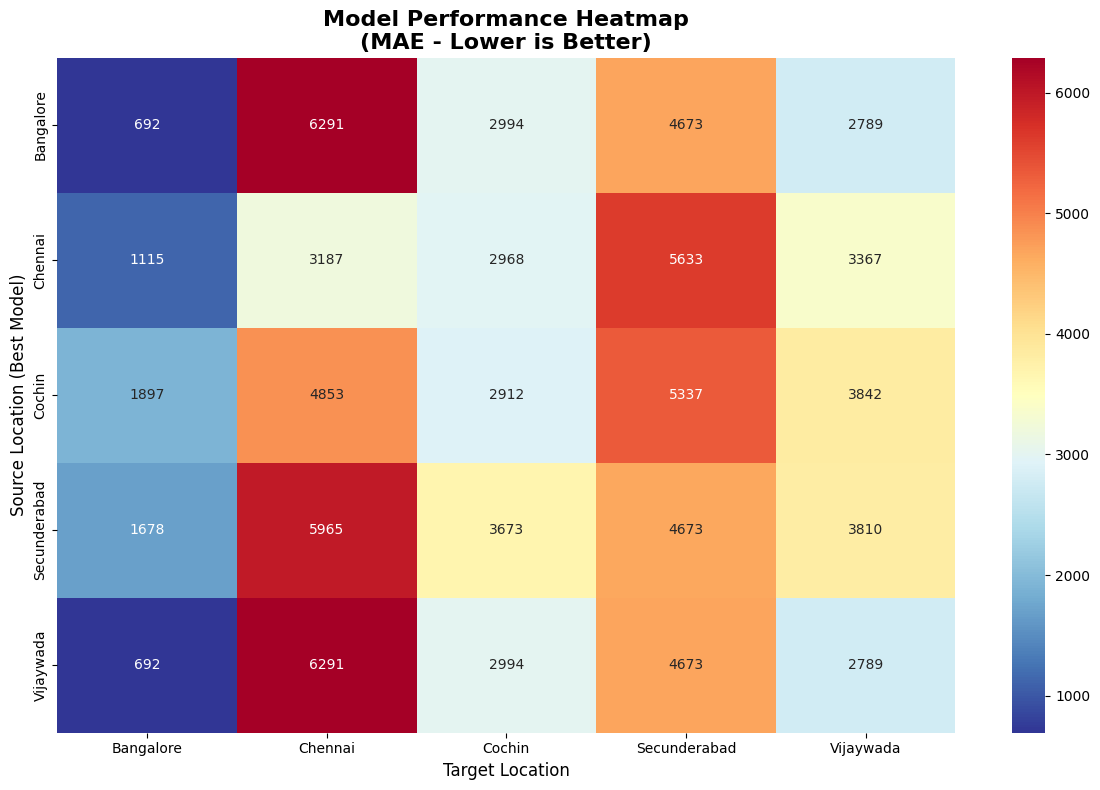

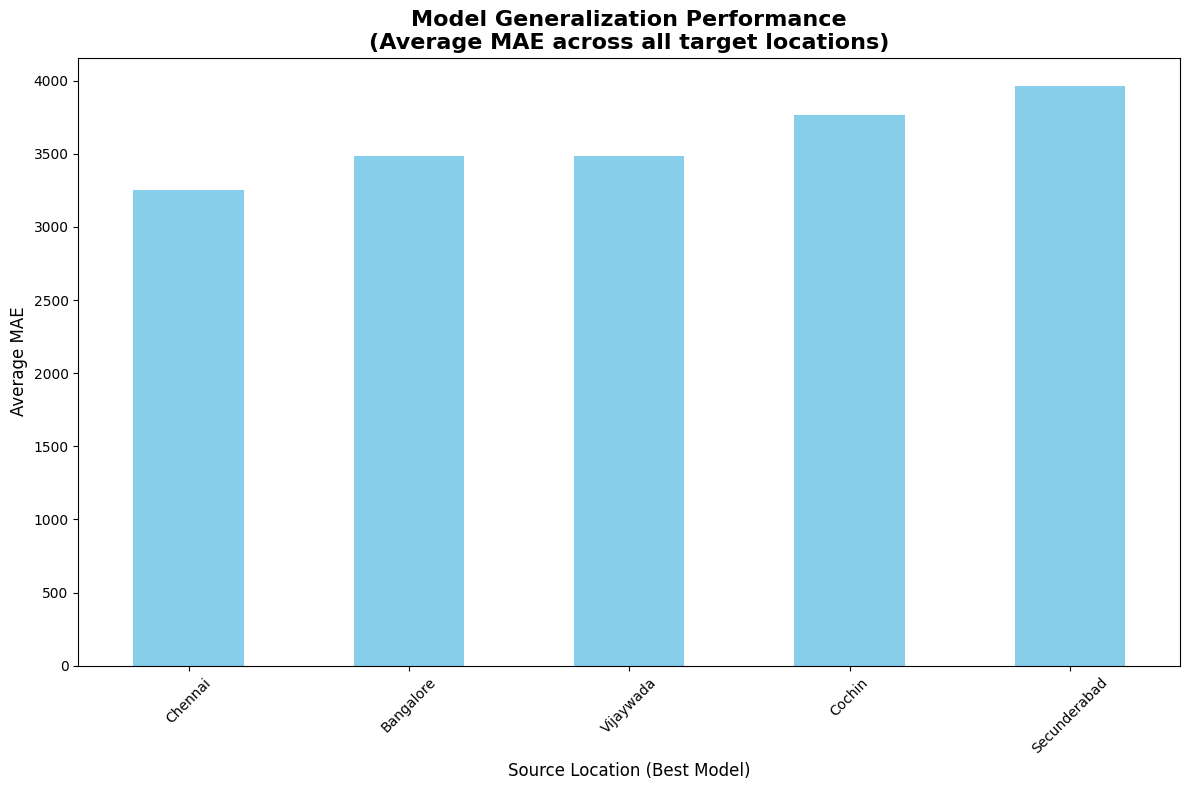

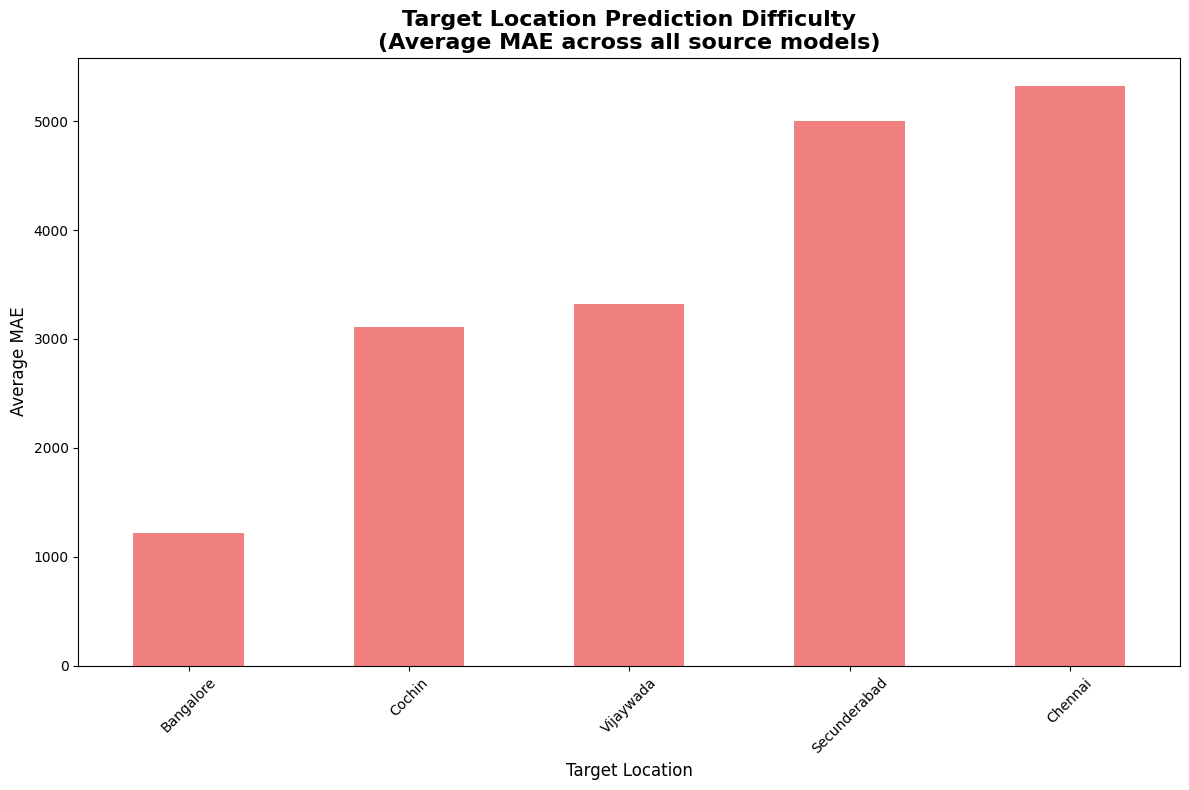

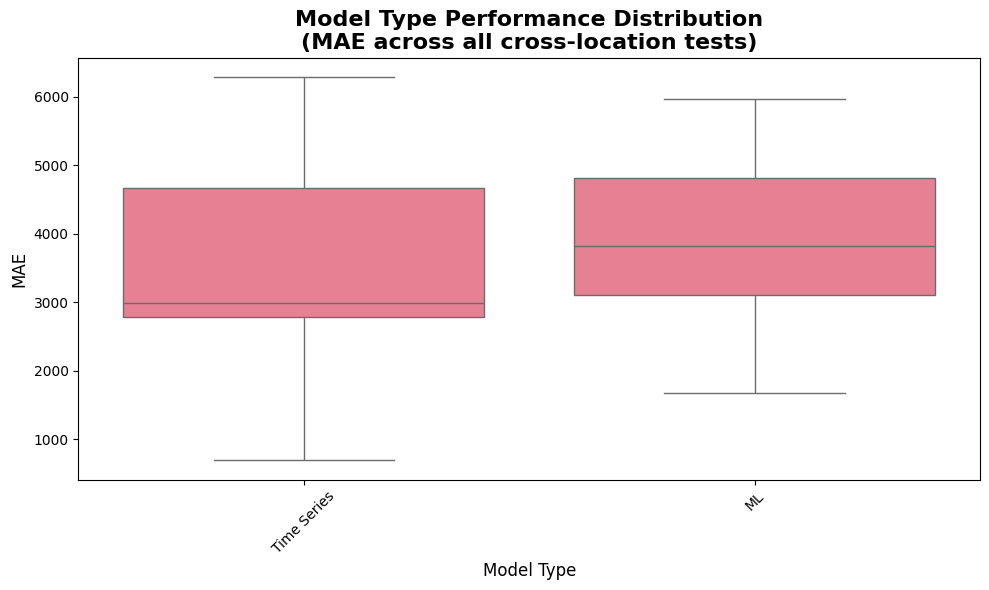


Visualizations saved to: ../outputs/model_results/plots/

Cross-location analysis completed successfully!


In [12]:
# Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create output directory for plots
os.makedirs('../outputs/model_results/plots', exist_ok=True)

# 1. Model performance heatmap
plt.figure(figsize=(12, 8))
pivot_data = cross_results_df.pivot_table(
    values='MAE', 
    index='Source_Location', 
    columns='Target_Location', 
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='RdYlBu_r')
plt.title('Model Performance Heatmap\n(MAE - Lower is Better)', fontsize=16, fontweight='bold')
plt.xlabel('Target Location', fontsize=12)
plt.ylabel('Source Location (Best Model)', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/model_results/plots/cross_location_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Model generalization comparison
plt.figure(figsize=(12, 8))
generalization_data = cross_results_df.groupby('Source_Location')['MAE'].mean().sort_values()
generalization_data.plot(kind='bar', color='skyblue')
plt.title('Model Generalization Performance\n(Average MAE across all target locations)', fontsize=16, fontweight='bold')
plt.xlabel('Source Location (Best Model)', fontsize=12)
plt.ylabel('Average MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/model_results/plots/model_generalization.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Target location difficulty
plt.figure(figsize=(12, 8))
difficulty_data = cross_results_df.groupby('Target_Location')['MAE'].mean().sort_values()
difficulty_data.plot(kind='bar', color='lightcoral')
plt.title('Target Location Prediction Difficulty\n(Average MAE across all source models)', fontsize=16, fontweight='bold')
plt.xlabel('Target Location', fontsize=12)
plt.ylabel('Average MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/model_results/plots/location_difficulty.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Model type comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=cross_results_df, x='Model_Type', y='MAE')
plt.title('Model Type Performance Distribution\n(MAE across all cross-location tests)', fontsize=16, fontweight='bold')
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/model_results/plots/model_type_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualizations saved to: ../outputs/model_results/plots/")
print("\nCross-location analysis completed successfully!")


In [13]:
# Final Summary and Recommendations
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Best generalizing model
best_generalizing_model = cross_results_df.groupby('Source_Location')['MAE'].mean().idxmin()
best_generalizing_mae = cross_results_df.groupby('Source_Location')['MAE'].mean().min()

print(f"\n1. BEST GENERALIZING MODEL:")
print(f"   Model: {best_generalizing_model} (best for {best_generalizing_model})")
print(f"   Average MAE across all locations: {best_generalizing_mae:.2f}")

# Easiest location to predict
easiest_location = cross_results_df.groupby('Target_Location')['MAE'].mean().idxmin()
easiest_mae = cross_results_df.groupby('Target_Location')['MAE'].mean().min()

print(f"\n2. EASIEST LOCATION TO PREDICT:")
print(f"   Location: {easiest_location}")
print(f"   Average MAE: {easiest_mae:.2f}")

# Hardest location to predict
hardest_location = cross_results_df.groupby('Target_Location')['MAE'].mean().idxmax()
hardest_mae = cross_results_df.groupby('Target_Location')['MAE'].mean().max()

print(f"\n3. HARDEST LOCATION TO PREDICT:")
print(f"   Location: {hardest_location}")
print(f"   Average MAE: {hardest_mae:.2f}")

# Best model type
best_model_type = cross_results_df.groupby('Model_Type')['MAE'].mean().idxmin()
best_type_mae = cross_results_df.groupby('Model_Type')['MAE'].mean().min()

print(f"\n4. BEST MODEL TYPE FOR GENERALIZATION:")
print(f"   Type: {best_model_type}")
print(f"   Average MAE: {best_type_mae:.2f}")

# Performance variance analysis
mae_variance = cross_results_df.groupby('Source_Location')['MAE'].std().sort_values()
most_consistent = mae_variance.idxmin()
least_consistent = mae_variance.idxmax()

print(f"\n5. MODEL CONSISTENCY:")
print(f"   Most Consistent: {most_consistent} (std: {mae_variance[most_consistent]:.2f})")
print(f"   Least Consistent: {least_consistent} (std: {mae_variance[least_consistent]:.2f})")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")



FINAL SUMMARY AND RECOMMENDATIONS

1. BEST GENERALIZING MODEL:
   Model: Chennai (best for Chennai)
   Average MAE across all locations: 3254.15

2. EASIEST LOCATION TO PREDICT:
   Location: Bangalore
   Average MAE: 1214.94

3. HARDEST LOCATION TO PREDICT:
   Location: Chennai
   Average MAE: 5317.54

4. BEST MODEL TYPE FOR GENERALIZATION:
   Type: Time Series
   Average MAE: 3409.92

5. MODEL CONSISTENCY:
   Most Consistent: Cochin (std: 1403.49)
   Least Consistent: Bangalore (std: 2110.16)

ANALYSIS COMPLETE
